In [1]:
from pykeen.datasets import get_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

In [2]:
kg = "WN18RR"
plots_output = "Output/Plots"
if not os.path.isdir(plots_output):
    os.makedirs(plots_output)
colors = ['#003560', '#8DAE10', '#ac329d']

In [3]:
# load the dataset
dataset = get_dataset(dataset=kg)

training_triples = dataset.training.mapped_triples
validation_triples = dataset.validation.mapped_triples
testing_triples = dataset.testing.mapped_triples

### I) Descriptive statistics over chosen knowledge graph

In [4]:
# helper function for the plots
def fill_up_counts(unique_output, length, fill_value):
    filled_up_list = [None] * length
    indices_greater_zero = set(unique_output[0].numpy())
    counts = list(unique_output[1].numpy())
    for i in range(length):
        if i in indices_greater_zero:
            filled_up_list[i] = counts.pop(0)
        else:
            filled_up_list[i] = fill_value
        
    return torch.tensor(filled_up_list)

#### KG frequency statistics

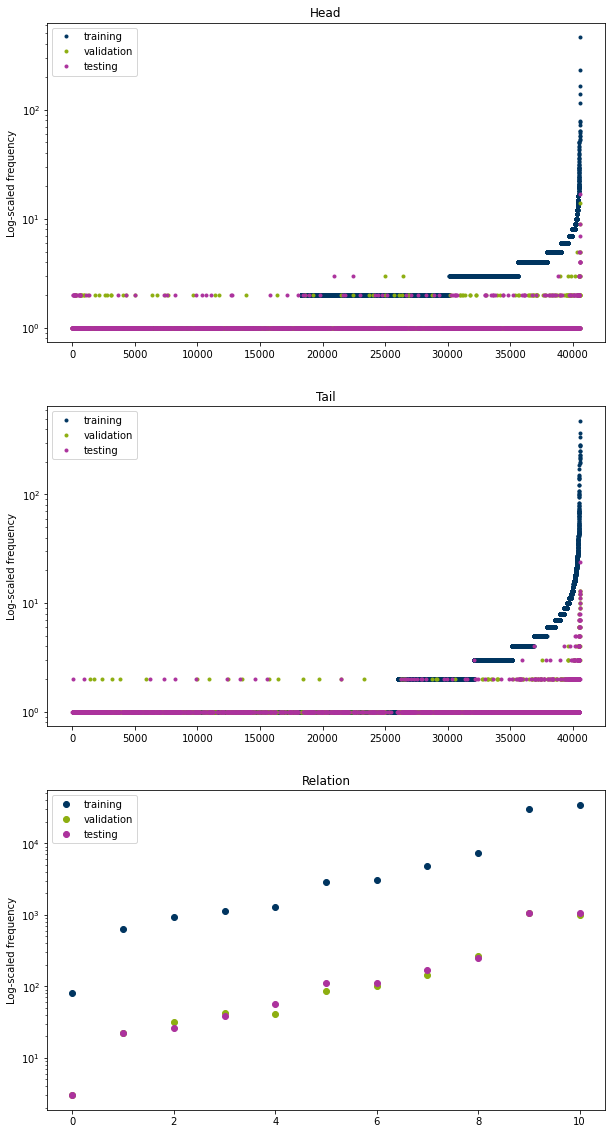

In [5]:
title = ["Head", "Relation", "Tail"]
lengths = [dataset.num_entities, dataset.num_relations, dataset.num_entities]
f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,20))

for i, ax in zip([0,2,1], [ax1,ax2,ax3]):

    training_frequencies = fill_up_counts(training_triples.index_select(index=torch.tensor([i]), dim=1).unique(return_counts=True), lengths[i], 0)
    sorted_training_frequencies = training_frequencies.sort()
    
    validation_frequencies = fill_up_counts(validation_triples.index_select(index=torch.tensor([i]), dim=1).unique(return_counts=True), lengths[i], float('nan'))
    sorted_validation_frequencies = validation_frequencies.index_select(dim=0, index=sorted_training_frequencies.indices)
    testing_frequencies = fill_up_counts(testing_triples.index_select(index=torch.tensor([i]), dim=1).unique(return_counts=True), lengths[i], float('nan'))
    sorted_testing_frequencies = testing_frequencies.index_select(dim=0, index=sorted_training_frequencies.indices)

    linestyle=""
    if lengths[i] > 100:
        marker="."
    else:
        #linestyle="-"
        marker="o"
    ax.plot(range(lengths[i]), sorted_training_frequencies.values, label="training", color=colors[0], marker=marker, linestyle=linestyle)
    ax.plot(range(lengths[i]), sorted_validation_frequencies, label="validation", color=colors[1], marker=marker, linestyle=linestyle)
    ax.plot(range(lengths[i]), sorted_testing_frequencies, label="testing", color=colors[2], marker=marker, linestyle=linestyle)

    ax.legend()
    ax.set_yscale('log')
    ax.set_title(title[i])
    ax.set_ylabel("Log-scaled frequency")
    
    plt.savefig(plots_output+"/frequency_statistics_{}.png".format(kg), dpi=300)

In [6]:
head_degrees_train = fill_up_counts(training_triples.index_select(index=torch.tensor([0]), dim=1).unique(return_counts=True), dataset.num_entities, 0)
head_degrees_val = fill_up_counts(validation_triples.index_select(index=torch.tensor([0]), dim=1).unique(return_counts=True), dataset.num_entities, 0)
head_degrees_test = fill_up_counts(testing_triples.index_select(index=torch.tensor([0]), dim=1).unique(return_counts=True), dataset.num_entities, 0)

print("Average head degree in training set: ", torch.mean((head_degrees_train).to(torch.float32)).item())
print("Max / min head degrees in training set: ", torch.max(head_degrees_train).to(torch.float32).item() , " / " , torch.min(head_degrees_train).to(torch.float32).item())
print("Average head degree in validation set: ", torch.mean((head_degrees_val).to(torch.float32)).item())
print("Max / min head degrees in validation set: ", torch.max(head_degrees_val).to(torch.float32).item() , " / " , torch.min(head_degrees_val).to(torch.float32).item())
print("Average head degree in testing set: ", torch.mean((head_degrees_test).to(torch.float32)).item())
print("Max / min head degrees in testing set: ", torch.max(head_degrees_test).to(torch.float32).item() , " / " , torch.min(head_degrees_test).to(torch.float32).item())
print("Average head degree (total): ", torch.mean((head_degrees_train+head_degrees_val+head_degrees_test).to(torch.float32)).item())

Average head degree in training set:  2.1409552097320557
Max / min head degrees in training set:  462.0  /  0.0
Average head degree in validation set:  0.06962696462869644
Max / min head degrees in validation set:  14.0  /  0.0
Average head degree in testing set:  0.07209251075983047
Max / min head degrees in testing set:  17.0  /  0.0
Average head degree (total):  2.282674551010132


In [7]:
tail_degrees_train = fill_up_counts(training_triples.index_select(index=torch.tensor([2]), dim=1).unique(return_counts=True), dataset.num_entities, 0)
tail_degrees_val = fill_up_counts(validation_triples.index_select(index=torch.tensor([2]), dim=1).unique(return_counts=True), dataset.num_entities, 0)
tail_degrees_test = fill_up_counts(testing_triples.index_select(index=torch.tensor([2]), dim=1).unique(return_counts=True), dataset.num_entities, 0)

print("Average degree in training set: ", torch.mean((tail_degrees_train).to(torch.float32)).item())
print("Max / min degrees in training set: ", torch.max(tail_degrees_train).to(torch.float32).item() , " / " , torch.min(tail_degrees_train).to(torch.float32).item())
print("Average degree in validation set: ", torch.mean((tail_degrees_val).to(torch.float32)).item())
print("Max / min degrees in validation set: ", torch.max(tail_degrees_val).to(torch.float32).item() , " / " , torch.min(tail_degrees_val).to(torch.float32).item())
print("Average degree in testing set: ", torch.mean((tail_degrees_test).to(torch.float32)).item())
print("Max / min degrees in testing set: ", torch.max(tail_degrees_test).to(torch.float32).item() , " / " , torch.min(tail_degrees_test).to(torch.float32).item())
print("Average degree (total): ", torch.mean((tail_degrees_train+tail_degrees_val+tail_degrees_test).to(torch.float32)).item())

Average degree in training set:  2.1409552097320557
Max / min degrees in training set:  476.0  /  0.0
Average degree in validation set:  0.06962696462869644
Max / min degrees in validation set:  13.0  /  0.0
Average degree in testing set:  0.07209251075983047
Max / min degrees in testing set:  24.0  /  0.0
Average degree (total):  2.282674551010132


#### Co-occurrence statistics

In [8]:
relation_indices_head = dataset.training.mapped_triples.index_select(dim=1, index=torch.tensor([0,1])).unique(dim=0)
# create the 2D tensor
relation_matrix_head = np.zeros((dataset.num_entities, dataset.num_relations), int)
relation_matrix_head[relation_indices_head[:,0], relation_indices_head[:,1]] = 1
relation_indices_tail = dataset.training.mapped_triples.index_select(dim=1, index=torch.tensor([2,1])).unique(dim=0)
# create the 2D tensor
relation_matrix_tail = np.zeros((dataset.num_entities, dataset.num_relations), int)
relation_matrix_tail[relation_indices_tail[:,0], relation_indices_tail[:,1]] = 1

cooccurrence_matrix_head = relation_matrix_head.T.dot(relation_matrix_head)
cooccurrence_matrix_tail = relation_matrix_head.T.dot(relation_matrix_tail)

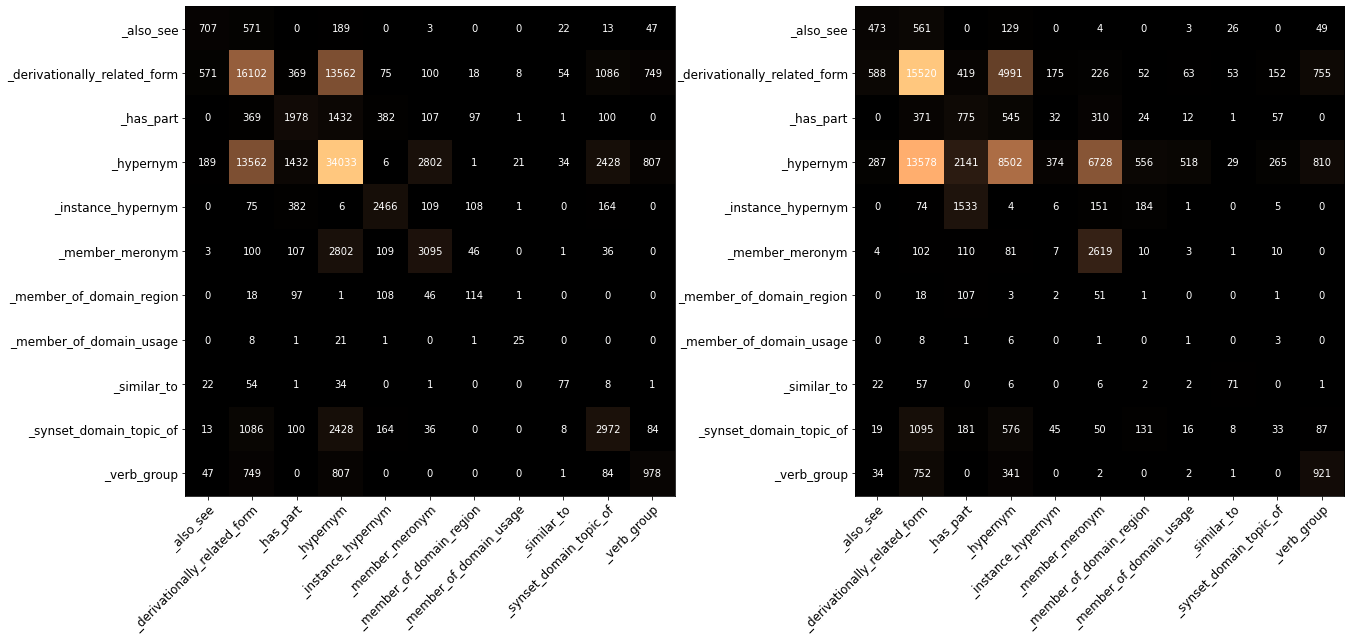

In [9]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(22,9))

relations = [v for v in dataset.training.relation_id_to_label.values()]
if len(relations) < 100:
    fontsize = 12
else:
    fontsize = 2

ax1.imshow(cooccurrence_matrix_head, cmap="copper")

ax1.set_xticks(np.arange(len(relations)))
ax1.set_yticks(np.arange(len(relations)))

ax1.set_xticklabels(rotation=45, ha="right", rotation_mode="anchor", labels=relations, fontdict={'fontsize':fontsize})
ax1.set_yticklabels(rotation=0, ha="right", rotation_mode="anchor", labels=relations, fontdict={'fontsize':fontsize})

if len(relations) < 20:
    for i in range(len(relations)):
        for j in range(len(relations)):
            text = ax1.text(j, i, cooccurrence_matrix_head[i, j],
                        ha="center", va="center", color="w")

#ax1.title("Co-occurrences of relations ")

ax2.imshow(cooccurrence_matrix_tail, cmap="copper")
ax2.set_xticks(np.arange(len(relations)))
ax2.set_yticks(np.arange(len(relations)))

ax2.set_xticklabels(rotation=45, ha="right", rotation_mode="anchor", labels=relations, fontdict={'fontsize':fontsize})
ax2.set_yticklabels(rotation=0, ha="right", rotation_mode="anchor", labels=relations, fontdict={'fontsize':fontsize})

if len(relations) < 20:
    for i in range(len(relations)):
        for j in range(len(relations)):
            text = ax2.text(j, i, cooccurrence_matrix_tail[i, j],
                        ha="center", va="center", color="w")

plt.savefig(plots_output+"/cooccurrence_matrices_{}.png".format(kg), dpi=500, transparent=False)


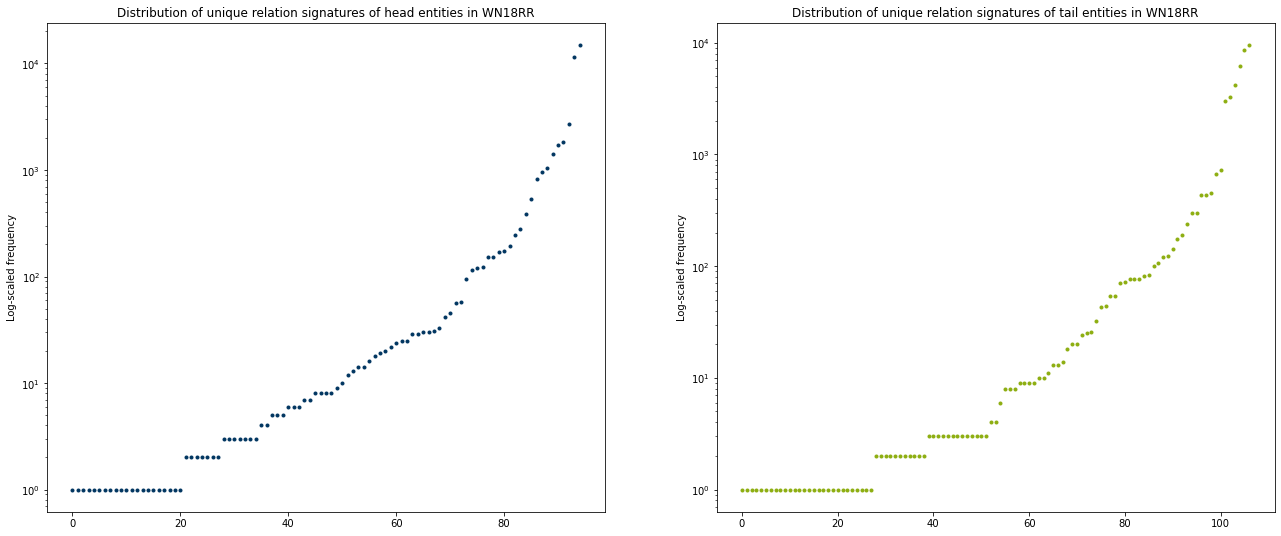

In [10]:
triple_frequencies_head = np.unique(relation_matrix_head, axis=0, return_counts=True)
triple_frequencies_tail = np.unique(relation_matrix_tail, axis=0, return_counts=True)

f, (ax1, ax2) = plt.subplots(1,2,figsize=(22,9))

ax1.plot(range(len(triple_frequencies_head[1])), np.sort(triple_frequencies_head[1]), color=colors[0], marker=".", linestyle="")
ax1.set_yscale("log")
ax1.set_title("Distribution of unique relation signatures of head entities in " + kg)
ax1.set_ylabel("Log-scaled frequency")

ax2.plot(range(len(triple_frequencies_tail[1])), np.sort(triple_frequencies_tail[1]), color=colors[1], marker=".", linestyle="")
ax2.set_yscale("log")
ax2.set_title("Distribution of unique relation signatures of tail entities in " + kg)
ax2.set_ylabel("Log-scaled frequency")

    
plt.savefig(plots_output+"/signature_frequency_statistics_{}.png".format(kg), dpi=300)

In [11]:
frequent_signatures = triple_frequencies_head[0][triple_frequencies_head[1]> (dataset.training.num_entities/10)]
frequencies = triple_frequencies_head[1][triple_frequencies_head[1]> (dataset.training.num_entities/10)]

print("There are {} unique signatures for entities in the head position.".format(len(triple_frequencies_head[1])))

#decoded_signature_list = []
relations_dict = dataset.training.relation_id_to_label
for fs, f in zip(frequent_signatures, frequencies):
    decoded_signature = []
    active_labels = np.where(fs==1)[0]
    for al in active_labels:
        decoded_signature.append(relations_dict[al])
    #decoded_signature_list.append(decoded_signature)
    print("Signature {} alone has a frequency of {} ({:.2f})%.".format(decoded_signature, f, f/dataset.training.num_entities*100))

exactly_1 = sum(triple_frequencies_head[1][triple_frequencies_head[1] == 1])
print("{} ({:.2f}%) of the signatures occur exactly once.".format(exactly_1, exactly_1/dataset.training.num_entities*100))
up_to_10 = sum(triple_frequencies_head[1][triple_frequencies_head[1] <= 10])
print("{} ({:.2f}%) of the signatures occur up to 10 times.".format(up_to_10, up_to_10/dataset.training.num_entities*100))
up_to_100 = sum(triple_frequencies_head[1][triple_frequencies_head[1] <= 100])
print("{} ({:.2f}%) of the signatures occur up to 100 times.".format(up_to_100, up_to_100/dataset.training.num_entities*100))
up_to_1000 = sum(triple_frequencies_head[1][triple_frequencies_head[1] <= 1000])
print("{} ({:.2f}%) of the signatures occur up to 1000 times.".format(up_to_1000, up_to_1000/dataset.training.num_entities*100))
up_to_10000 = sum(triple_frequencies_head[1][triple_frequencies_head[1] <= 10000])
print("{} ({:.2f}%) of the signatures occur up to 10000 times.".format(up_to_10000, up_to_10000/dataset.training.num_entities*100))

There are 95 unique signatures for entities in the head position.
Signature ['_hypernym'] alone has a frequency of 14976 (36.92)%.
Signature ['_derivationally_related_form', '_hypernym'] alone has a frequency of 11595 (28.59)%.
21 (0.05%) of the signatures occur exactly once.
162 (0.40%) of the signatures occur up to 10 times.
861 (2.12%) of the signatures occur up to 100 times.
5282 (13.02%) of the signatures occur up to 1000 times.
13988 (34.49%) of the signatures occur up to 10000 times.


In [12]:
frequent_signatures = triple_frequencies_tail[0][triple_frequencies_tail[1]> (dataset.training.num_entities/10)]
frequencies = triple_frequencies_tail[1][triple_frequencies_tail[1]> (dataset.training.num_entities/10)]

print("There are {} unique signatures in the tail position.".format(len(triple_frequencies_tail[1])))

#decoded_signature_list = []
relations_dict = dataset.training.relation_id_to_label
for fs, f in zip(frequent_signatures, frequencies):
    decoded_signature = []
    active_labels = np.where(fs==1)[0]
    for al in active_labels:
        decoded_signature.append(relations_dict[al])
    #decoded_signature_list.append(decoded_signature)
    print("Signature {} alone has a frequency of {} ({:.2f}%).".format(decoded_signature, f, f/dataset.training.num_entities*100))

exactly_1 = sum(triple_frequencies_tail[1][triple_frequencies_tail[1] == 1])
print("{} ({:.2f}%) of the signatures occur exactly once.".format(exactly_1, exactly_1/dataset.training.num_entities*100))
up_to_10 = sum(triple_frequencies_tail[1][triple_frequencies_tail[1] <= 10])
print("{} ({:.2f}%) of the signatures occur up to 10 times.".format(up_to_10, up_to_10/dataset.training.num_entities*100))
up_to_100 = sum(triple_frequencies_tail[1][triple_frequencies_tail[1] <= 100])
print("{} ({:.2f}%) of the signatures occur up to 100 times.".format(up_to_100, up_to_100/dataset.training.num_entities*100))
up_to_1000 = sum(triple_frequencies_tail[1][triple_frequencies_tail[1] <= 1000])
print("{} ({:.2f}%) of the signatures occur up to 1000 times.".format(up_to_1000, up_to_1000/dataset.training.num_entities*100))
up_to_10000 = sum(triple_frequencies_tail[1][triple_frequencies_tail[1] <= 10000])
print("{} ({:.2f}%) of the signatures occur up to 10000 times.".format(up_to_10000, up_to_10000/dataset.training.num_entities*100))

There are 107 unique signatures in the tail position.
Signature [] alone has a frequency of 8678 (21.40%).
Signature ['_member_meronym'] alone has a frequency of 6233 (15.37%).
Signature ['_derivationally_related_form'] alone has a frequency of 9589 (23.64%).
Signature ['_derivationally_related_form', '_hypernym'] alone has a frequency of 4155 (10.24%).
28 (0.07%) of the signatures occur exactly once.
183 (0.45%) of the signatures occur up to 10 times.
1129 (2.78%) of the signatures occur up to 100 times.
5633 (13.89%) of the signatures occur up to 1000 times.
40559 (100.00%) of the signatures occur up to 10000 times.


### II) Sizes and overlaps of EII

In [13]:
head_simi = scipy.sparse.load_npz("Output/EII/{}/ESNSStandard_AbsoluteSimilarity_h.npz".format(kg)).tolil()
tail_simi = scipy.sparse.load_npz("Output/EII/{}/ESNSStandard_AbsoluteSimilarity_t.npz".format(kg)).tolil()
head_simi_relaxed = scipy.sparse.load_npz("Output/EII/{}/ESNSRelaxed_AbsoluteSimilarity_h_k1000.npz".format(kg))
tail_simi_relaxed = scipy.sparse.load_npz("Output/EII/{}/ESNSRelaxed_AbsoluteSimilarity_t_k1000.npz".format(kg))

In [14]:
n_head, n_tail, n_head_relaxed, n_tail_relaxed = [], [], [], []
for h,t,h_r,t_r in zip(head_simi, tail_simi, head_simi_relaxed, tail_simi_relaxed):
    n_head += [np.min([np.sum(h.todense()[0]!=0),1000])] # bool so that values are binarized
    n_tail += [np.min([np.sum(t.todense()[0]!=0),1000])]
    n_head_relaxed += [np.min([np.sum(h_r.todense()[0]!=0),1000])]
    n_tail_relaxed += [np.min([np.sum(t_r.todense()[0]!=0),1000])]

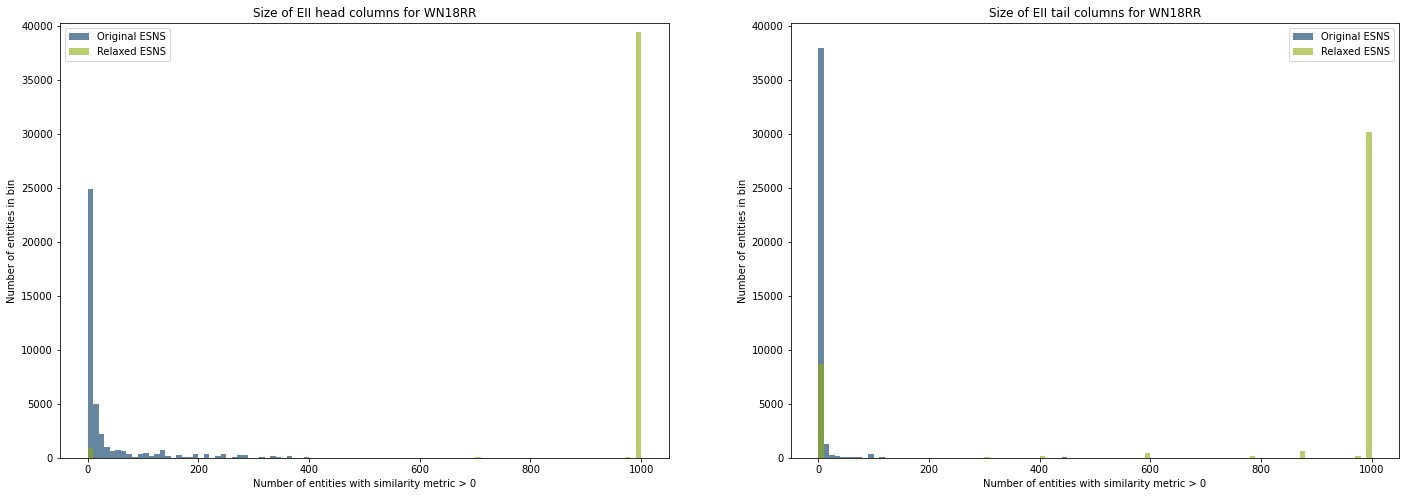

In [15]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(24,8))

hist1 = ax1.hist(n_head, bins=100, color=colors[0], alpha=0.6, range=(0,1000))
hist2 = ax1.hist(n_head_relaxed, bins=100, color=colors[1], alpha=0.6, range=(0,1000))
ax1.set_xlabel("Number of entities with similarity metric > 0")
ax1.set_ylabel("Number of entities in bin")
ax1.legend(["Original ESNS", "Relaxed ESNS"])
ax1.set_title("Size of EII head columns for {}".format(kg))

hist3 = ax2.hist(n_tail, bins=100, color=colors[0], alpha=0.6, range=(0,1000))
hist4 = ax2.hist(n_tail_relaxed, bins=100, color=colors[1], alpha=0.6, range=(0,1000))
ax2.set_xlabel("Number of entities with similarity metric > 0")
ax2.set_ylabel("Number of entities in bin")
ax2.legend(["Original ESNS", "Relaxed ESNS"], )
ax2.set_title("Size of EII tail columns for {}".format(kg))

max_freq = np.max([np.max(hist[0]) for hist in [hist1,hist2,hist3,hist4]])
ax1.set_ylim((None,max_freq+800))
ax2.set_ylim((None,max_freq+800))

    
plt.savefig(plots_output+"/EII_sizes_{}.png".format(kg), dpi=300)

In [16]:
print("Mean/median EII head column size original ESNS: ", np.mean(n_head), np.median(n_head))
print("Mean/median EII tail column size original ESNS: ", np.mean(n_tail), np.median(n_tail))
print("Mean/median EII head column size relaxed ESNS: ", np.mean(n_head_relaxed), np.median(n_head_relaxed))
print("Mean/median EII tail column size relaxed ESNS: ", np.mean(n_tail_relaxed), np.median(n_tail_relaxed))

Mean/median EII head column size original ESNS:  33.849749747281734 6.0
Mean/median EII tail column size original ESNS:  4.556867772874084 0.0
Mean/median EII head column size relaxed ESNS:  975.6433837126162 1000.0
Mean/median EII tail column size relaxed ESNS:  774.9643975443181 1000.0


#### Calculate size of N to achieve a specified sampling probability for similar entities

In [17]:
import math

max_column_size = 100
target_p = 0.7

mean_eii_size = np.mean([np.median(n_head), np.median(n_tail)])

n_standard = math.log(-target_p + 1, (dataset.num_entities-np.min([max_column_size, mean_eii_size])) / dataset.num_entities)
print("Estimated N to reach target p in ESNS Standard (median column size: {}): {}".format(int(np.min([max_column_size, mean_eii_size])), int(np.ceil(n_standard))))

mean_eii_size = np.mean([np.median(n_head_relaxed), np.median(n_tail_relaxed)])

n_relaxed = math.log(-target_p + 1, (dataset.num_entities-np.min([max_column_size, mean_eii_size])) / dataset.num_entities)
print("Estimated N to reach target p in ESNS Relaxed (median column size: {}): {}".format(int(np.min([max_column_size, mean_eii_size])), int(np.ceil(n_relaxed))))

Estimated N to reach target p in ESNS Standard (median column size: 3): 16277
Estimated N to reach target p in ESNS Relaxed (median column size: 100): 488


#### Compare EII

In [18]:
max_column_size=100

eii_head_standard= scipy.sparse.load_npz('Output/EII/{}/ESNSStandard_AbsoluteSimilarity_h.npz'.format(kg)).tolil()

ent = 0
for data, row in zip(eii_head_standard.data, eii_head_standard.rows):
    if max_column_size < len(row):
        d, r = zip(*sorted(zip(data, row), reverse=True)[:max_column_size])
        eii_head_standard.data[ent] = list(d)
        eii_head_standard.rows[ent] = list(r)
    ent +=1

eii_head_standard = eii_head_standard.astype('bool')

eii_head_relaxed= scipy.sparse.load_npz('Output/EII/{}/ESNSRelaxed_AbsoluteSimilarity_h.npz'.format(kg)).tolil().astype('bool')
eii_head_rbm_reconstructed = scipy.sparse.load_npz('Output/EII/{}/ESNSRidle_CosineSimilarity_reconstructed_h.npz'.format(kg)).tolil().astype('bool')
eii_head_rbm_compressed = scipy.sparse.load_npz('Output/EII/{}/ESNSRidle_CosineSimilarity_compressed_h.npz'.format(kg)).tolil().astype('bool')

eii_tail_standard= scipy.sparse.load_npz('Output/EII/{}/ESNSStandard_AbsoluteSimilarity_t.npz'.format(kg)).tolil()

ent = 0
for data, row in zip(eii_tail_standard.data, eii_tail_standard.rows):
    if max_column_size < len(row):
        d, r = zip(*sorted(zip(data, row), reverse=True)[:max_column_size])
        eii_tail_standard.data[ent] = list(d)
        eii_tail_standard.rows[ent] = list(r)
    ent +=1

eii_tail_standard = eii_head_standard.astype('bool')

eii_tail_relaxed= scipy.sparse.load_npz('Output/EII/{}/ESNSRelaxed_AbsoluteSimilarity_t.npz'.format(kg)).tolil().astype('bool')
eii_tail_rbm_reconstructed = scipy.sparse.load_npz('Output/EII/{}/ESNSRidle_CosineSimilarity_reconstructed_t.npz'.format(kg)).tolil().astype('bool')
eii_tail_rbm_compressed = scipy.sparse.load_npz('Output/EII/{}/ESNSRidle_CosineSimilarity_compressed_t.npz'.format(kg)).tolil().astype('bool')

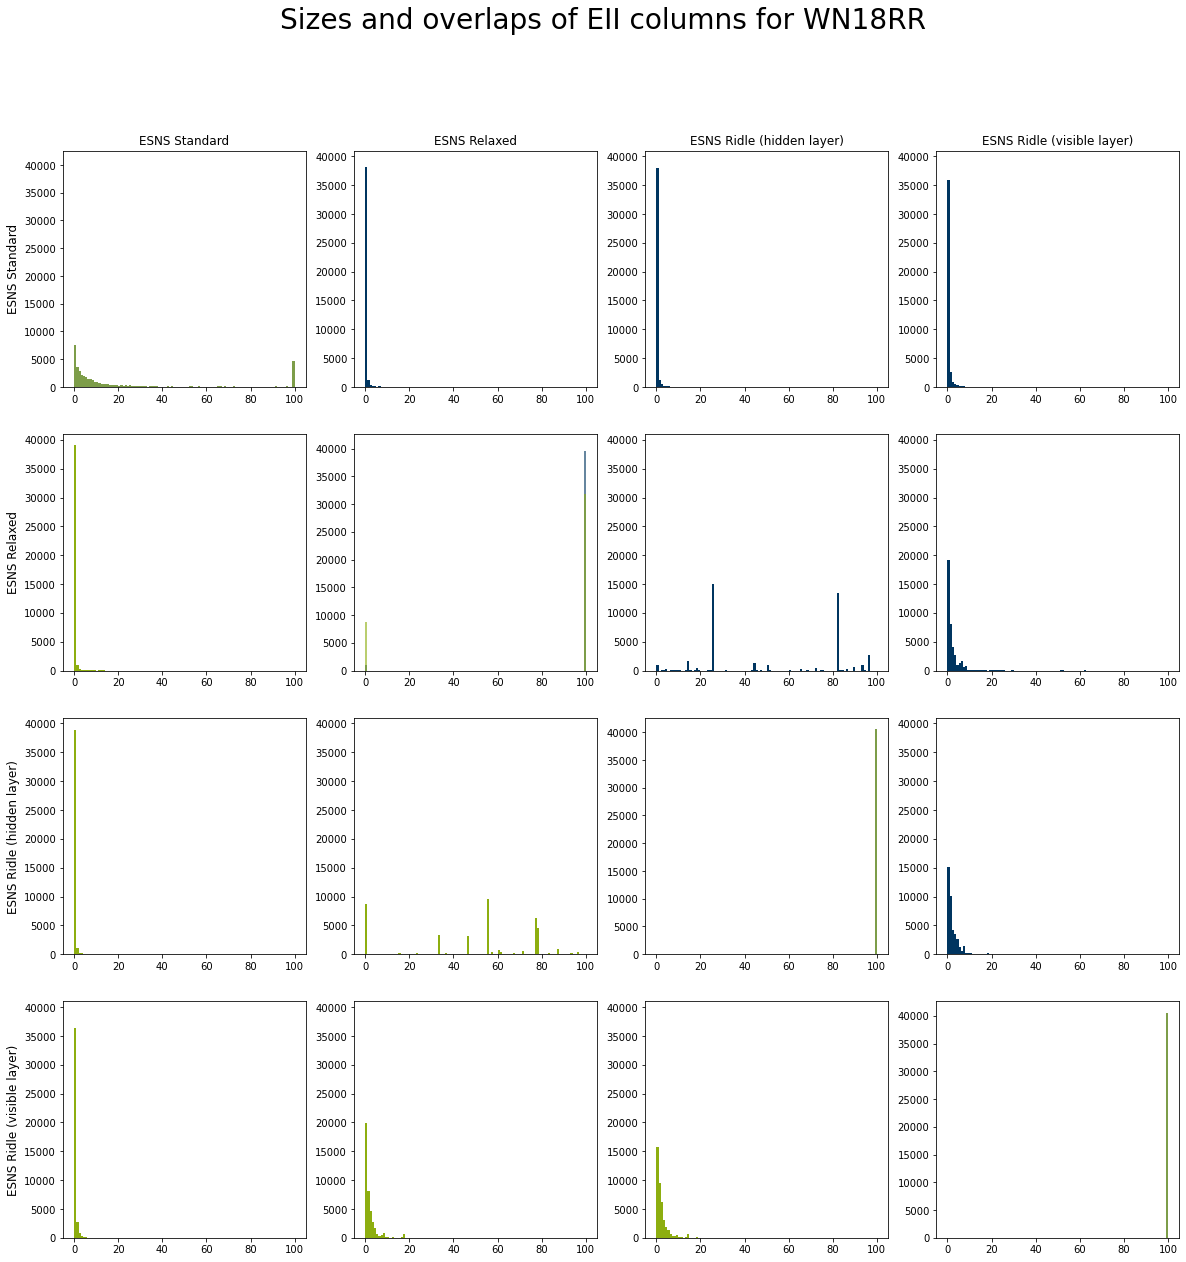

In [19]:
f, axes = plt.subplots(4,4,figsize=(20,20))
f.suptitle("Sizes and overlaps of EII columns for {}".format(kg), fontsize=28)
head = [eii_head_standard, eii_head_relaxed, eii_head_rbm_compressed, eii_head_rbm_reconstructed, ]
tail = [eii_tail_standard, eii_tail_relaxed, eii_tail_rbm_compressed, eii_tail_rbm_reconstructed, ]

max_y_lim_main = 0
max_y_lim_side = 0

for i in range(len(head)):
    for j  in range(len(head)): 
        
        if i==j:
            col = [colors[0], colors[1]]
            head_or_tail = [head, tail]
            alpha=0.6
        elif i<j:
            col = [colors[0]]
            head_or_tail = [head]
            alpha=1
        else: 
            col = [colors[1]]
            head_or_tail = [tail]
            alpha=1

        for h_t, c in zip(head_or_tail, col):
            overlaps = h_t[i].multiply(h_t[j]).sum(axis=1)
            hist = axes[i, j].hist(overlaps, color=c, bins=100, range=(0,100), alpha=alpha)
            # keep track of the largest y limit of main diagonal and to its sides
            if (i==j) and (max(hist[0]) > max_y_lim_main):
                max_y_lim_main = max(hist[0])
            elif (i!=j) and (max(hist[0]) > max_y_lim_side):
                max_y_lim_side = max(hist[0])

titles = ["ESNS Standard", "ESNS Relaxed", "ESNS Ridle (hidden layer)", "ESNS Ridle (visible layer)"]
for ax, col in zip(axes[0], titles):
    ax.set_title(col)

for ax, row in zip(axes[:,0], titles):
    ax.set_ylabel(row,size='large')

# to unify y-scale for all subplots
for i, ax in enumerate(axes.reshape(-1)):
    if i % 5 == 0: # main diagonal
        ax.set_ylim(0,(max_y_lim_main+(max_y_lim_main*0.05)))
    else:
        ax.set_ylim(0,(max_y_lim_side+(max_y_lim_side*0.05)))

plt.savefig(plots_output+"/EII_overlaps_{}.png".format(kg), dpi=500)